In [21]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import anndata
import math
import scipy.stats as stats
from scipy import interpolate
from scipy.interpolate import BSpline, splrep
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.size"] = 10
plt.rcParams['figure.figsize'] = (8,8)

In [2]:
# set a working directory
wdir = "/Users/samibening/Projects/Bachelor/"
os.chdir(wdir)

In [3]:
adata = anndata.read_h5ad(os.path.join(os.getcwd(), "data/output/adata.h5ad"))
adata

AnnData object with n_obs × n_vars = 5397 × 16719
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden_res0_6', 'manual_celltype_annotation', 'celltypist_cell_label', 'celltypist_conf_score', 'celltypist_cell_label_coarse'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_colors', 'hvg', 'leiden', 'leiden_res0_6_colors', 'neighbors', 'pca', 'sampleID_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'int_norm', 'log_int_norm', 'log_norm', 'norm', 'raw'
    obsp: 'connectivitie

In [4]:
# set your gene of interest (GOI) here:

GOI = "CASP8"
cell_type = 'T Cell'

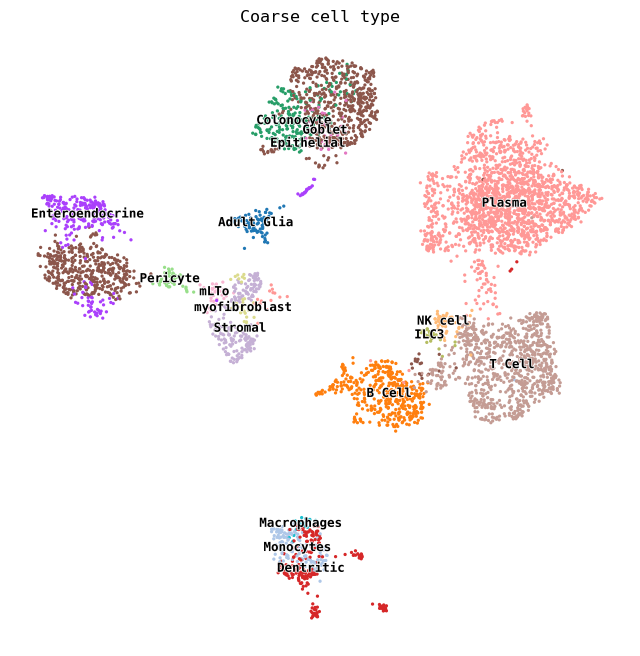

In [22]:
sc.pl.umap(
    adata,    color=["celltypist_cell_label_coarse"],
    frameon=False, legend_loc="on data", title="Coarse cell type", legend_fontsize=9, legend_fontweight=600, 
    legend_fontoutline=1
)

In [6]:
def clean_data(df, col, threshold = 99.75):
    data = df[col].to_numpy().flatten()
    data = data[data <= np.percentile(data, threshold)]
    return data

def find_thresholds(filtered):
    range = (abs(max(filtered)) + abs(min(filtered)))
    step = range / float(4)
    very_low = min(filtered) + step
    low = min(filtered) + step*2
    middle = min(filtered) + step*3
    #print(round(very_low, 2), round(low, 2), round(middle, 2), round(max(filtered), 2))
    return very_low, low, middle, max(filtered)

def classify_exp_level(df, filtered, col, print_quantile = False, print_gene_num = False):
    very_low, low, middle, high = find_thresholds(filtered)
    def func(x):
        if x <= very_low:
            return "very_low"
        elif very_low < x <= low:
            return "low"
        elif low < x <= middle:
            return "middle"
        elif middle < x <= high:
            return "high"
        else:
            return "very_high"
    df['expr_class'] = df[col].apply(func)
    if print_quantile:
        print(str(round(stats.percentileofscore(df[col], very_low), 4)) + ", " + str(round(stats.percentileofscore(df[col], low), 4)) + ", " + 
              str(round(stats.percentileofscore(df[col], middle), 4)) + ", " + str(round(stats.percentileofscore(df[col], high), 4)) + ", 99.7500")
    if print_gene_num:
        print("Number of genes per category: ")
        print("very_low: " + str(len(df[df['expr_class'] == 'very_low'])))
        print("low: " + str(len(df[df['expr_class'] == 'low'])))
        print("middle: " + str(len(df[df['expr_class'] == 'middle'])))
        print("high: " + str(len(df[df['expr_class'] == 'high'])))
        print("very_high: " + str(len(df[df['expr_class'] == 'very_high'])))
    return df

def make_df(adata, col='log1p(means)', layer='log_norm', print_quantile=False, print_gene_num=False):
    sc.pp.highly_variable_genes(adata, layer=layer)
    df = adata.var.sort_values(['means'])
    df['gene_num'] = range(len(df))
    df['log(means)'] = np.log(df['means'])
    df['log1p(means)'] = np.log1p(df['means'])

    filtered = clean_data(df, col=col, threshold=99.75) # can choose upper outlier threshold here
    df_new = classify_exp_level(df =df, filtered=filtered, col=col, print_quantile=print_quantile, print_gene_num = print_gene_num)
    return df_new

In [7]:
def explain_expr_celltypes(adata, col='log1p(means)', layer='log_norm', print_quantile=False, print_gene_num=False):
    print(GOI + " Expression across cell types: ")
    print("\t [cell type]; [expression classification]; [avg. expression over this cell type]")
    for cell_type in adata.obs['celltypist_cell_label_coarse'].unique():
        subset = adata[adata.obs['celltypist_cell_label_coarse'] == cell_type]
        df = make_df(subset, col)
        print("\t " + cell_type + ";  " + str(df.loc[df.index == GOI]['expr_class'].values[0]) + ";  " + str(round(df.loc[df.index == GOI][col].values[0], 3)))

In [8]:
explain_expr_celltypes(adata)

CASP8 Expression across cell types: 
	 [cell type]; [expression classification]; [avg. expression over this cell type]
	 mLTo;  very_low;  0.034
	 Monocytes;  very_low;  0.171
	 B Cell;  very_low;  0.221
	 Epithelial;  very_low;  0.135
	 T Cell;  low;  0.399
	 Dentritic;  very_low;  0.162
	 Plasma;  very_low;  0.184
	 Enteroendocrine;  very_low;  0.163
	 Colonocyte;  very_low;  0.12
	 myofibroblast;  very_low;  0.141
	 Stromal;  very_low;  0.12
	 Adult Glia;  very_low;  0.027
	 Pericyte;  very_low;  0.054
	 ILC3;  very_low;  0.266
	 NK cell;  very_low;  0.357
	 Macrophages;  very_low;  0.269
	 Goblet;  very_low;  0.246


In [ ]:
# TODO threshold for expecting dropout zeros 

def dropout_threshold(adata):
    df = adata.to_df()
    # finalized threshold to come here
    return df

In [9]:
# find overall expression of all genes, highlighting GOI

def plot_expr_class(adata, cell_type=None, col='log1p(means)', print_quantile=True, print_gene_num = True):
    title = "Overall expression across all cell types"
    if cell_type != None:
        title = str("Overall expression in " + cell_type + " cells")
        if cell_type in adata.obs['celltypist_cell_label_coarse'].unique():
            adata = adata[adata.obs['celltypist_cell_label_coarse'] == cell_type]
        elif cell_type in adata.obs['celltypist_cell_label'].unique():
            adata = adata[adata.obs['celltypist_cell_label'] == cell_type]
        else:
            print("Cell type not found. Please check spelling.")
            return
    
    df_new = make_df(adata, print_quantile=print_quantile, print_gene_num = print_gene_num)

    g = sns.scatterplot(data=df_new, x='gene_num',  y=col, hue='expr_class', linewidth=0)
    annotation = str(GOI + " (" + df_new.loc[df_new.index == GOI]['expr_class'].values[0] + ")")
    highlight_y = df_new.loc[df_new.index == GOI][col]
    highlight_x = df_new.loc[df_new.index == GOI]['gene_num']
    g.scatter(highlight_x, highlight_y, color = 'yellow', linewidth=1)
    props = dict(facecolor='black', width=1, headwidth=5, headlength=8)
    g.annotate(annotation, (highlight_x, highlight_y), (highlight_x - 1000, highlight_y+0.7), arrowprops=props, ha='right') #TODO make arrow go down if gene is very high on
    g.set_title(title)
    g.set_xlabel("ranked genes")
    g.set_ylabel("log1p(mean expression)")
    plt.show()

90.8188, 97.769, 99.0909, 99.7488, 99.7500
Number of genes per category: 
very_low: 15184
low: 1162
middle: 221
high: 110
very_high: 42


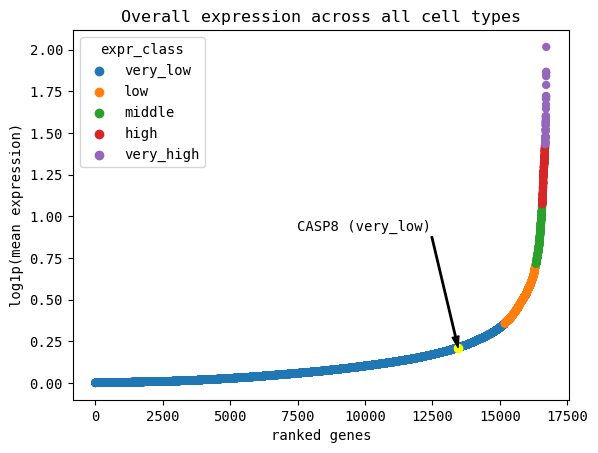

In [10]:
plot_expr_class(adata)

90.2805, 97.5298, 99.1208, 99.7488, 99.7500
Number of genes per category: 
very_low: 15094
low: 1212
middle: 266
high: 105
very_high: 42


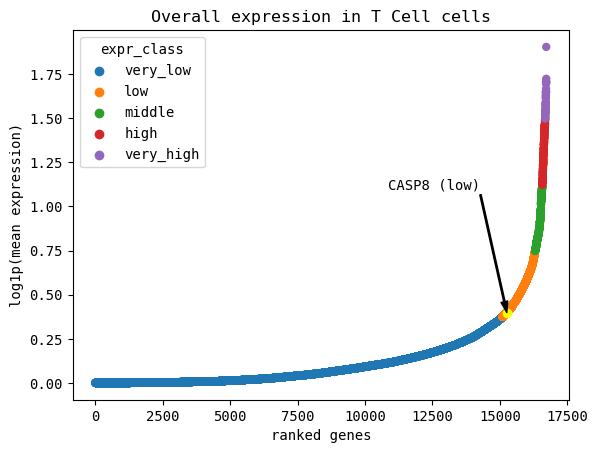

In [10]:
# find overall expression of all genes within cell type of interest, highlighting GOI

plot_expr_class(adata, cell_type='T Cell')

In [14]:
plt.rcParams["font.size"] = 11

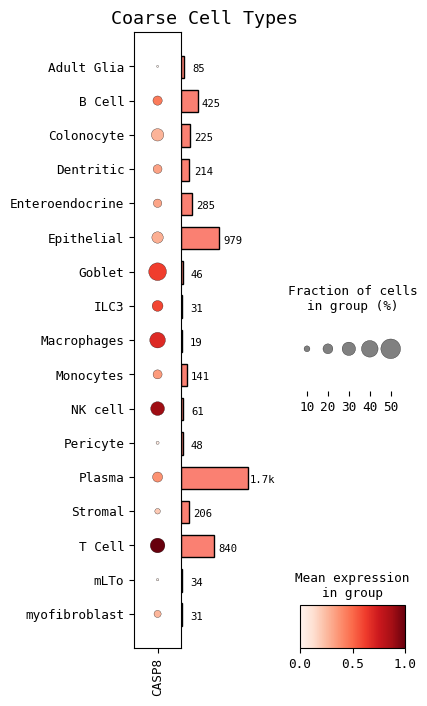

In [15]:
# find expression across cell types of GOI here

markers= GOI
ax1 = sc.pl.dotplot(adata, var_names=markers, groupby='celltypist_cell_label_coarse', 
                    return_fig=True, standard_scale='var', title="Coarse Cell Types", figsize=(3.5,8))
ax1.add_totals().show()

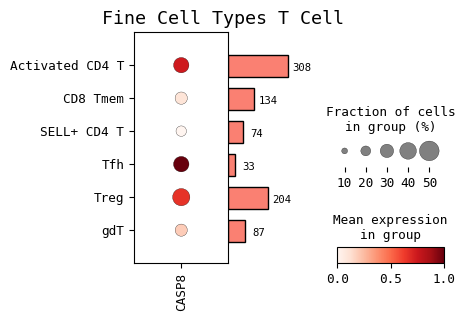

In [16]:
# TODO: make interactive: click on cell type to see fine cell types

ax1 = sc.pl.dotplot(adata[adata.obs['celltypist_cell_label_coarse'] == cell_type], var_names=markers, groupby='celltypist_cell_label', 
                    return_fig=True, standard_scale='var', title=str('Fine Cell Types ' + cell_type), figsize=(4,3))
ax1.add_totals().show()

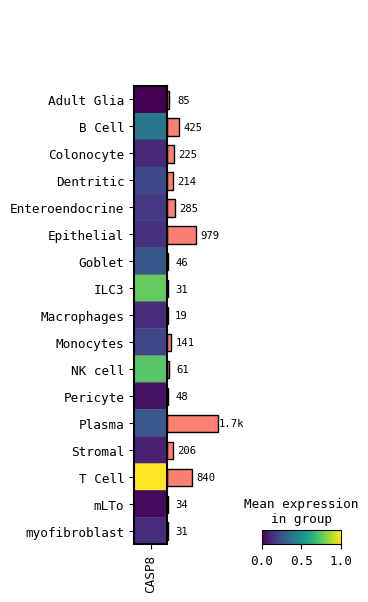

In [17]:
ax2 = sc.pl.matrixplot(adata, markers, groupby='celltypist_cell_label_coarse', return_fig=True, layer='log_int_norm', standard_scale='var')
ax2.add_totals().style(edge_color='black').show()

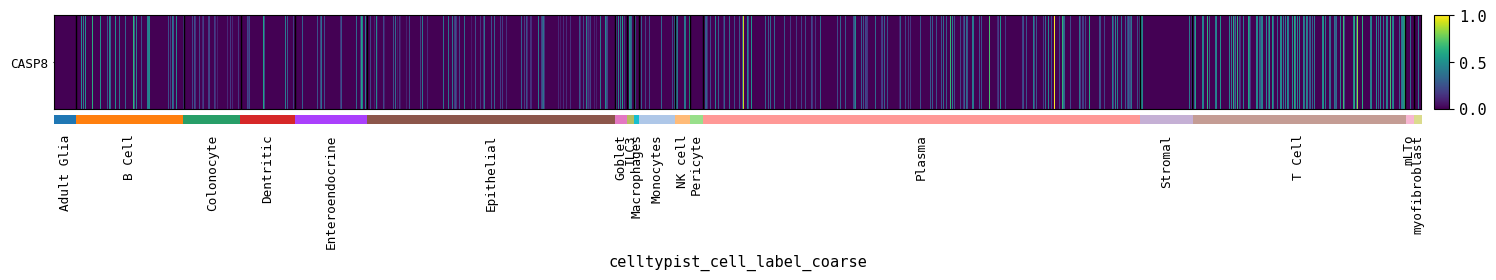

In [18]:
sc.pl.heatmap(adata, markers, groupby='celltypist_cell_label_coarse', swap_axes=True, figsize=(18,1.5), layer='log_norm', standard_scale='var')

In [19]:
def plot_per_cell_type(adata, cell_type, layer='log_norm'):
        data = adata[:, GOI]
        df = data.to_df(layer=layer)
        df['cell_type'] = data.obs['celltypist_cell_label_coarse']
        df['sample'] = data.obs['sampleID']

        df_cell = df[df['cell_type'] == cell_type]
        df_cell['cell_type'] = df_cell['cell_type'].cat.remove_unused_categories()

        # Create a catplot with box plots, small space between boxes
        plot = sns.catplot(data=df_cell, x='cell_type', y=GOI, hue='sample', kind='box', height=5, aspect=0.999)

        # Adjust the figure layout
        plot.fig.subplots_adjust(top=0.9)
        plot.fig.suptitle(str(GOI) + " Expression Across " + cell_type)

        # Calculate non-zero counts per sample
        non_zero_counts_per_sample = df_cell.groupby('sample')[GOI].apply(lambda x: (x != 0).sum())

        # Add legend with hue color and non-zero counts per sample
        handles, labels = plot._legend_data.values(), non_zero_counts_per_sample.values
        plot.ax.legend(handles, labels, title='Non-zero Counts', loc='lower left', bbox_to_anchor=(1, 0.7))

        # Show the plot
        plt.show()

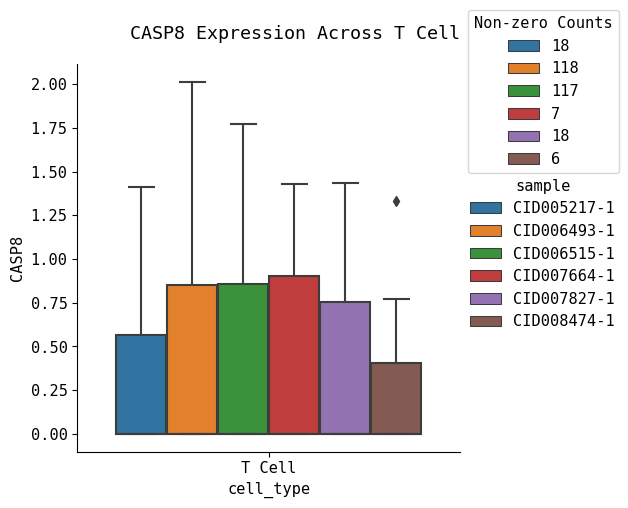

In [20]:
# GOI expression across samples (patients) with extra info on non-zero counts per patient
plot_per_cell_type(adata, cell_type='T Cell')

In [15]:
adata.to_df(layer='log_norm')

index,AL669831.5,LINC00115,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,AL645608.7,HES4,ISG15,...,AC145212.1,MAFIP,AC011043.1,AL592183.1,AC007325.4,AL354822.1,AC004556.1,AC233755.2,AC233755.1,AC240274.1
CID005217-1-AACAGGGGTGAATGAT,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1.463760,2.033968,...,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
CID005217-1-AACCAACGTCATCGCG,0.697436,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,2.204836,1.104327,...,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
CID005217-1-AACCACAAGAGGCCAT,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
CID005217-1-AACCTTTAGCTCGGCT,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1.466735,0.981152,...,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
CID005217-1-AACGAAATCCAAAGGG,0.000000,0.000000,0.0,0.0,1.004203,0.0,0.0,0.000000,0.000000,1.822804,...,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CID008474-1-TTTGATCGTGCCGGTT,0.000000,0.000000,0.0,0.0,0.684229,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
CID008474-1-TTTGGAGGTCGATGCC,0.000000,0.000000,0.0,0.0,0.458188,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
CID008474-1-TTTGGTTCATTCTCCG,0.000000,0.243684,0.0,0.0,0.000000,0.0,0.0,0.243684,0.243684,0.000000,...,0.0,0.00000,0.00000,0.0,0.0,0.243684,0.0,0.0,0.0,0.243684
CID008474-1-TTTGGTTTCCGAACGC,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.293832,0.413657,0.000000,...,0.0,0.15767,0.15767,0.0,0.0,0.157670,0.0,0.0,0.0,0.000000


In [11]:
# for cell type: mean expression of a gene (x) vs. percentace of cells where this gene is detected (y) (wihtin a cell type)

def pl_expression_vs_detection(adata, cell_type=None, layer='log_norm', col='log1p(means)', ax=None, return_df = False):
    
    title=str(GOI)
    if cell_type != None:
        title = str("Overall expression in " + cell_type + " cells")
        if cell_type in adata.obs['celltypist_cell_label_coarse'].unique():
            adata = adata[adata.obs['celltypist_cell_label_coarse'] == cell_type]
        elif cell_type in adata.obs['celltypist_cell_label'].unique():
            adata = adata[adata.obs['celltypist_cell_label'] == cell_type]
        else:
            print("Cell type not found. Please check spelling.")
            return
    else:
        title = "All cell types"
        
    df = make_df(adata, col, layer=layer)

    # calculate percentage of cells (of the given cell type) where each gene is detected
    subset_df = adata.to_df(layer=layer)
    #nonzero_detected = pd.DataFrame(subset_df.astype(bool).sum(axis=0) / len(df) * 100, columns=['percent_detected'])
    nonzero_detected = pd.DataFrame(np.count_nonzero(subset_df, axis=0) / len(subset_df)*100, columns=['percent_detected'], index=subset_df.columns)
    df = df.join(nonzero_detected, how='left').sort_values(['gene_num'], ascending=True)
    if return_df:
        return df
        
    # plot mean expression of a gene (x) vs. percentage of cells where this gene is detected (y)
    ax = sns.scatterplot(data=df, x=col, y='percent_detected', hue='expr_class', linewidth=0)
    ax.set_title(str(title+ ": mean expression vs. percentage detected"))
    ax.legend(title='Expression Class', loc='lower left', bbox_to_anchor=(1, 0))

    annotation = str(GOI)
    highlight_y = df.loc[df.index == GOI]['percent_detected']
    highlight_x = df.loc[df.index == GOI][col]
    ax.scatter(highlight_x, highlight_y, color = 'yellow', linewidth=1)
    props = dict(facecolor='black', width=1, headwidth=5, headlength=8)
    ax.annotate(annotation, (highlight_x, highlight_y), (highlight_x-0.1, highlight_y+20), arrowprops=props)
    plt.show()
    return ax


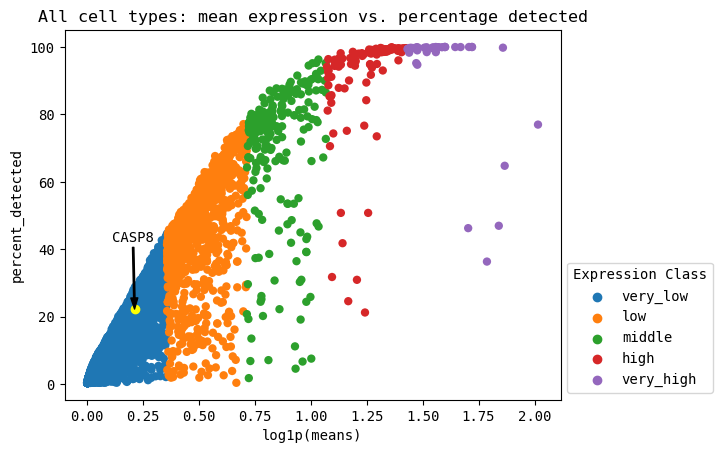

<Axes: title={'center': 'All cell types: mean expression vs. percentage detected'}, xlabel='log1p(means)', ylabel='percent_detected'>

In [14]:
pl_expression_vs_detection(adata)
# very interesting!! 

### Fit curve to the max curve seen above to calculate threshold for lower genes, curve elbow, etc. 

In [23]:
# make bins and take maximum of each bin to get (x,y) points to fit sigmoid curve to
df = pl_expression_vs_detection(adata, cell_type='Plasma', return_df=True)
df['percent_detected'] = df['percent_detected']/100
df_bins = df.groupby(pd.cut(df['log1p(means)'], np.arange(0, max(df['log1p(means)']), 0.05))).max() 
#TODO issue here that the log1p(means) value is also always the max, as in the very top of the bin instead of the median for example? 
df_bins = df_bins.dropna()
# fit function here
xdata = df_bins['log1p(means)'].values
ydata = df_bins['percent_detected']
for bin, value in ydata.items():
    if (bin.right > 1.25) and (value < 0.7):
        ydata.loc[bin] = 0.999
ydata = ydata.values
df_bins.tail()

,n_cells,highly_variable,means,dispersions,dispersions_norm,gene_num,log(means),log1p(means),expr_class,percent_detected
log1p(means),,,,,,,,,,
"(1.6, 1.65]",5397.0,0.0,4.122572,3.131673,0.809077,16711.0,1.416477,1.633657,very_high,1.000000
"(1.65, 1.7]",5395.0,0.0,4.305445,3.352774,1.000000,16712.0,1.459881,1.668734,very_high,1.000000
"(1.85, 1.9]",5385.0,0.0,5.611379,4.798494,0.707107,16714.0,1.724797,1.888792,very_high,0.998842
"(1.95, 2.0]",1962.0,0.0,6.082448,7.967224,1.000000,16715.0,1.805407,1.957620,very_high,0.999000
"(2.0, 2.05]",3495.0,0.0,6.587778,7.942641,1.000000,16717.0,1.885216,2.026539,very_high,0.982629


In [27]:
# fit and plot splines
tck = splrep(xdata, ydata, s=0.0009, k=3)
tck_s = splrep(xdata, ydata, s=len(xdata))

# derivatives of spline function
yders = interpolate.spalde(xdata, tck)
yders_df = pd.DataFrame(yders, columns=['y', 'dy', 'd2y', 'd3y'], index= xdata)
yders_df['d3y_diff'] = yders_df['d3y'].diff().fillna(0)
# identify any changes in direction of the third derivative
infls = yders_df[yders_df['d3y_diff'] != 0].index
infls

Index([0.4975267605816357, 0.9467385443893931, 1.384571200389861], dtype='float64')

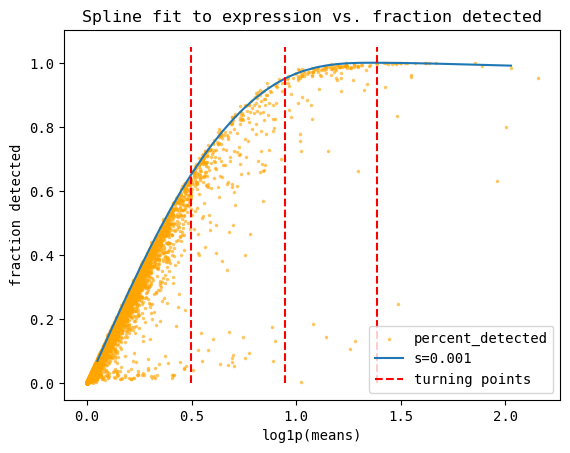

In [28]:
# plot data vs fitted spline with inflection points
fig, ax2 = plt.subplots(1,1)
ax2.scatter(data=df, x='log1p(means)', y='percent_detected', alpha=0.5, color='orange', s=2.5)
ax2.plot(xdata, BSpline(*tck)(xdata), label='s=0.001')
#ax2.plot(xdata, BSpline(*tck_s)(xdata), label=f's={len(xdata)}')
ax2.set_title("Spline fit to expression vs. fraction detected")
ax2.set_xlabel("log1p(means)")
ax2.set_ylabel("fraction detected")
ax2.vlines(infls, 0, 1.05, color='red', linestyles='dashed', label='turning points')
ax2.legend()
plt.show()

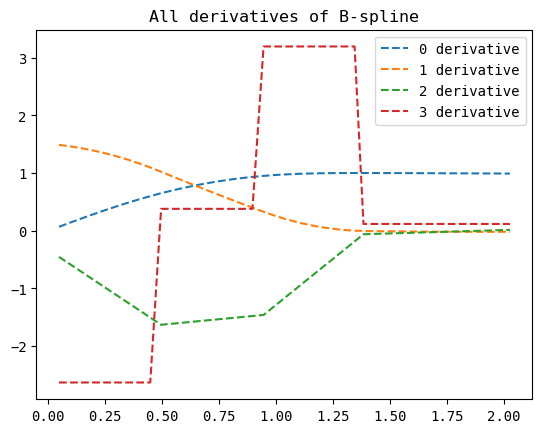

In [29]:
# second derivative of spline function
yders = interpolate.spalde(xdata, tck)
plt.figure()
for i in range(4):
   plt.plot(xdata, [d[i] for d in yders], '--', label=f"{i} derivative")
plt.legend()
plt.title('All derivatives of B-spline')
plt.show()

### Automatically identify lower outliers (clue to look at celltype subset)

In [30]:
# calculate the orthogonal distance of each point (gene) from the spline
# if greater than a certain value (threshold), then it is an outlier

# calculate the distance of each point from the linear interpolation of its respective section
def calc_distance_point(point, p1, p2):
    x0, y0 = point
    x1, y1 = p1
    x2, y2 = p2
    return abs((x2-x1)*(y1-y0) - (x1-x0)*(y2-y1)) / math.sqrt((y2-y1)**2 + (x2-x1)**2) # orthogonal distance formula

def calc_distance(x, y, inflection=infls):
    # make  linear interpolations of the sigmoid function, eg. one from 0 to inflection point, one from inflection point to max

    lowest = [0,0]
    highest = [x[-1], BSpline(*tck)(x[-1])]
    
    distance = []
    complete_data = pd.DataFrame(data={'x': x.values, 'y': y.values})
    segment = complete_data[complete_data['x'] < inflection[0]]


    for i, j in zip(segment['x'], segment['y']):
        distance.append(calc_distance_point([i,j], lowest, [inflection[0], BSpline(*tck)(inflection[0])]))

    for infls in range(len(inflection)-1):
        segment = complete_data[(complete_data['x'] >= inflection[infls]) & (complete_data['x'] < inflection[infls+1])]
        for i, j in zip(segment['x'], segment['y']):
            distance.append(calc_distance_point([i,j], [inflection[infls], BSpline(*tck)(inflection[infls])], [inflection[infls+1], BSpline(*tck)(inflection[infls+1])]))
    
    segment = complete_data[(complete_data['x'] >= inflection[-1])]
    for i, j in zip(segment['x'], segment['y']):
        distance.append(calc_distance_point([i,j], [inflection[-1], BSpline(*tck)(inflection[-1])], highest))

    return distance
    

detecter = df[['log1p(means)', 'percent_detected']]
detecter['distance'] = calc_distance(detecter['log1p(means)'], detecter['percent_detected'])
detecter['is_outlier'] = detecter['distance'] > 0.15
detecter

,log1p(means),percent_detected,distance,is_outlier
index,,,,
LINC02323,1.000000e-12,0.000000,7.943924e-13,False
FAM3D-AS1,1.000000e-12,0.000000,7.943924e-13,False
SIGLEC14,1.000000e-12,0.000000,7.943924e-13,False
AFF2,1.000000e-12,0.000000,7.943924e-13,False
SLITRK2,1.000000e-12,0.000000,7.943924e-13,False
...,...,...,...,...
JCHAIN,1.888792e+00,0.989577,3.704576e-03,False
IGLC3,1.957620e+00,0.632310,3.599460e-01,True
IGLC2,2.004694e+00,0.798494,1.931028e-01,True


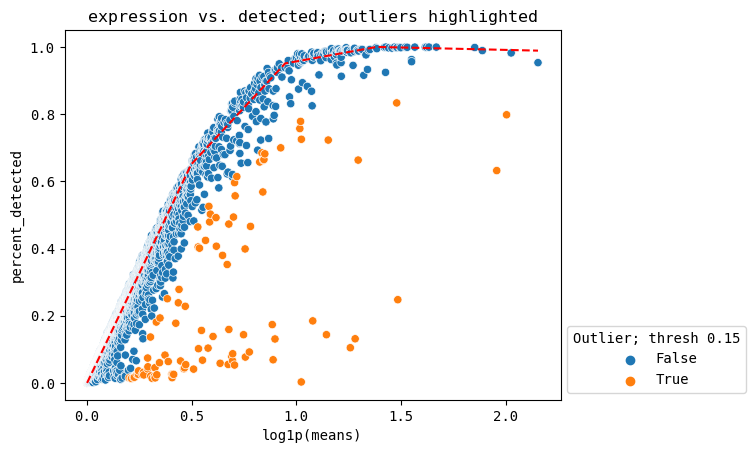

In [31]:
# make plot with outliers highlighted   
mask = detecter['log1p(means)'].isin(infls)
inflections = detecter[mask]
inflections['spline'] = BSpline(*tck)(inflections['log1p(means)'])
inflections['log1p(means)'][0]

fig, ax = plt.subplots(1,1)
sns.scatterplot(data=detecter, x='log1p(means)', y='percent_detected', hue='is_outlier', alpha=1, ax=ax)
ax.plot([0, inflections['log1p(means)'][0], inflections['log1p(means)'][1], inflections['log1p(means)'][2], detecter['log1p(means)'][-1]], 
        [0, inflections['spline'][0], inflections['spline'][1], inflections['spline'][2], BSpline(*tck)(detecter['log1p(means)'][-1])], color='red', linestyle='dashed')
ax.set_title("expression vs. detected; outliers highlighted")
ax.legend(title='Outlier; thresh 0.15', loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

## Summarize expression vs. percent detected information in text output

In [ ]:
# method to summarize expression vs. percentage detected for GOI
# location on the curve: above or below inflection point, a.k.a are dropouts expected or not
# steepness of the curve: how quickly does the gene go from not detected to detected
# if the GOI is a lower outlier or not: a.k.a hint to look into cell type subsets

def summarize_expression_vs_detection(adata, GOI, cell_type=None, layer='log_norm', col='log1p(means)', ax=None):
    summary = ""
    # TODO

    return summary

## Extras 

In [32]:
# function to plot relationship between total counts mean and percent detected value
# x: cell type specific total counts mean, y: cell type specific percent detected value 

def pl_tc_vs_pd(adata, ax, method='mean', return_df = False, layer='log_norm'):

    # calculate mean total counts per cell type
    subset_df = adata.to_df(layer='log_norm')
    means = adata.obs.groupby(['celltypist_cell_label']).mean()
    new_df = pd.DataFrame(data=means['total_counts']) #df with cell type as index and mean 'total_counts' as column

    temp = {}
    # calculate percentage of cells (per cell type) where each gene is detected (average)
    for cell_type in adata.obs['celltypist_cell_label'].unique():
        subset = subset_df[adata.obs['celltypist_cell_label'] == cell_type]
        nonzero_detected = pd.DataFrame(np.count_nonzero(subset, axis=0) / len(subset)*100, columns=[cell_type], index=subset.columns)
        if method=='median':
            temp[cell_type] = nonzero_detected[cell_type].median()
        else:
            temp[cell_type] = nonzero_detected[cell_type].mean()

    new_df['percent_detected'] = new_df.index.map(temp)
    new_df = new_df.sort_values(['total_counts'], ascending=True)
    if return_df:
        return new_df
    
    # plot new_df: x=total_counts, y=percent_detected
    for row, column in new_df.iterrows():
        ax.scatter(column['total_counts'], column['percent_detected'], c=np.random.rand(1, 3), label=row) 
        ax.annotate(row, (column['total_counts'], column['percent_detected']), (column['total_counts']+100, column['percent_detected']+0.1), fontsize=6.5)

    ax.set_title("Mean total counts vs. mean percent detected, per cell type")
    ax.set_xlabel("Mean total counts")
    ax.set_ylabel(str(method + " percent non-zero"))
    
    return ax

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1 = pl_tc_vs_pd(adata, ax=ax1, method='median')
plt.show()
# TODO look online for cell size estimates for each cell type and compare to total counts? 

In [127]:
# function to plot histogram for given adata layer
def clean_data(adata, layer_name, threshold = 99.75, remove_zeros = False):
    df = adata.to_df(layer=layer_name)
    data = df.to_numpy().flatten()
    
    cutoff = np.percentile(df.values, threshold)
    if remove_zeros:
        data = data[data != 0]
    data = data[data <= cutoff]
    
    return data
    

def plot_hist(adata, ax, layer_name, bin_num=1000): # higher bin numbers made zeros in tc_norm_log disappear? 
    data = clean_data(adata, layer_name)
    
    hist, edges = np.histogram(data, bins=bin_num)

    ax.bar(edges[:-1], hist, width = max(edges)/bin_num, color='#0504aa', align='edge')
    ax.set_title(layer_name)
    ax.set_xlim(min(edges), np.percentile(data, 99.75))
    ax.set_ylim(0, np.percentile(hist, 99.75))
    ax.grid(axis='y', alpha=0.75)
    ax.set_xlabel('Gene Expression')
    ax.set_ylabel('Frequency')
    ax.vlines(np.percentile(data, 97.5), ymin=0, ymax=max(hist), linestyle="--", color="r", label='97.5%')
        
    ax.legend()
    
    return ax

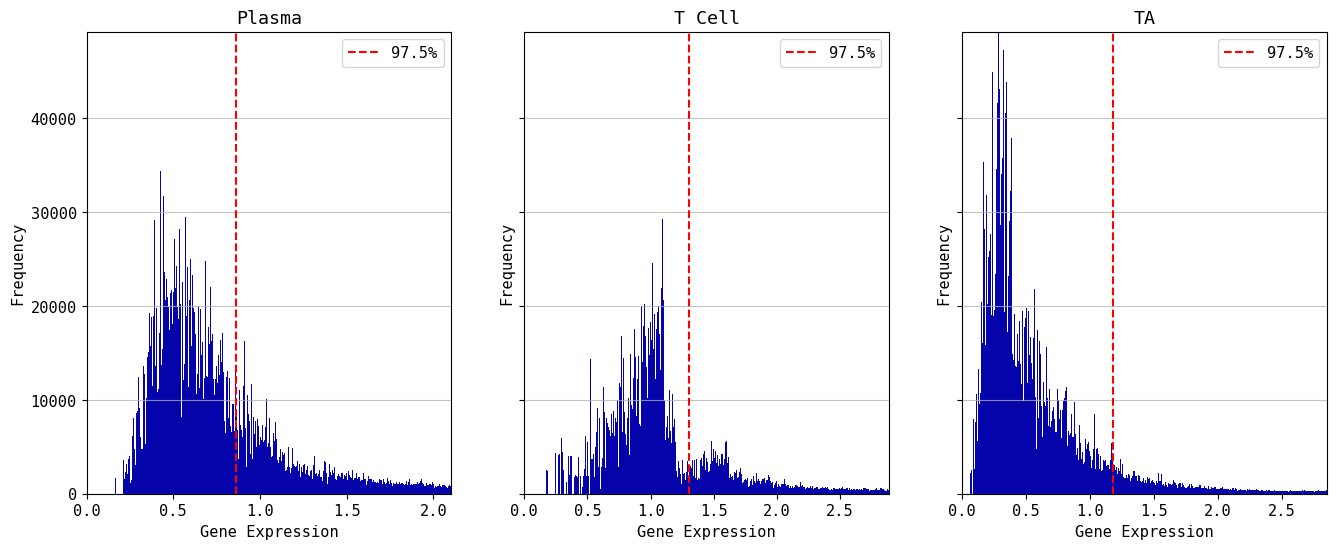

In [129]:
fig, (ax2, ax3, ax4) = plt.subplots(1,3, figsize=(16,6), sharey=True)
ax2 = plot_hist(adata[adata.obs['celltypist_cell_label_coarse'] == 'Plasma'], ax=ax2, layer_name='log_norm', bin_num=500)
ax2.set_title("Plasma")
ax3 = plot_hist(adata[adata.obs['celltypist_cell_label_coarse'] == 'T Cell'], ax=ax3, layer_name='log_norm', bin_num=500)
ax3.set_title("T Cell")
ax4 = plot_hist(adata[adata.obs['celltypist_cell_label'] == 'TA'], ax=ax4, layer_name='log_norm', bin_num=500)
ax4.set_title("TA")
plt.show()

In [91]:
# function to calculate the percent change between two layers (e.g. log_norm and magic)
def calculate_percent_change(adata, layer1, layer2, type='value'):
    df1 = adata.to_df(layer=layer1)
    df2 = adata.to_df(layer=layer2)
    
    nonzero_detected = pd.DataFrame(np.count_nonzero(df1, axis=0), columns=['df1_nonzero'], index=df1.columns)
    nonzero_detected['df2_nonzero'] = np.count_nonzero(df2, axis=0)
    if type == 'value':
        # calculate percent change of all values (including 0s)
        nonzero_detected['percent_change'] = (nonzero_detected['df2_nonzero'] - nonzero_detected['df1_nonzero']) / nonzero_detected['df1_nonzero'] * 100
    elif type=='nonzero':
        # calculate percentage of the number of values that changed from 0 to non-zero
        nonzero_detected['percent_change'] = (nonzero_detected['df2_nonzero'] - nonzero_detected['df1_nonzero']) / len(df1) * 100
    nonzero_detected['percent_change'] = nonzero_detected['percent_change'].fillna(0)
    return nonzero_detected

# function to plot the percent change between two layers (e.g. log_norm and magic)
def plot_percent_change(adata, layer1, layer2, cell_type, type='value', col='log1p(means)'):
    title=str(GOI)
    if cell_type != None:
        title = str("Overall expression in " + cell_type + " cells")
        if cell_type in adata.obs['celltypist_cell_label_coarse'].unique():
            adata = adata[adata.obs['celltypist_cell_label_coarse'] == cell_type]
        elif cell_type in adata.obs['celltypist_cell_label'].unique():
            adata = adata[adata.obs['celltypist_cell_label'] == cell_type]
        else:
            print("Cell type not found. Please check spelling.")
            return
    else:
        title = "All cell types"
        
    df = make_df(adata, col, layer=layer1)

    changes = calculate_percent_change(adata, layer1, layer2, type=type)
    df = df.join(changes, how='left').sort_values(['gene_num'], ascending=True)
        
    # plot mean expression of a gene (x) vs. percentage of cells where this gene is detected (y)
    ax = sns.scatterplot(data=df, x=col, y='percent_change', hue='expr_class', linewidth=0)
    ax.set_title(str(title + ": Expression vs. Change in Detection"))
    ax.legend(title='Expression Class', loc='lower left', bbox_to_anchor=(1, 0))
    plt.show()
    return ax